# The advantage of using the minimal line-of-sight model
<b>Author</b>: Natalie B. Hogg

We use the LOS effects that we implemented in `lenstronomy` to show that degeneracies appear when analysing an image using the full LOS model, but these degeneracies are eliminated in the minimal model.

<a name="contents"></a>
1. [Set up: import packages, set up plots, cosmology and telescope settings](#setup)
2. [Create the source](#create_source)
3. [Create the lens](#create_lens)
4. [Create the image](#create_image)
5. [Fit the image with different models](#analyse_image)
 1. [Fit with perfect LOS model](#fit_two) ([result](#contour_two))
 2. [Fit with perfect minimal model](#fit_three) ([result](#contour_three))

## Set up <a name="setup"></a>

### Import packages

In [1]:
import numpy as np
import cmath
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rc, rcParams, rcParamsDefault
from mpl_toolkits import mplot3d, axes_grid1
from chainconsumer import ChainConsumer

from multiprocessing import cpu_count
ncpu = cpu_count()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# this is where the figures will be saved
outpath  = r'/home/natalie/Documents/Projects/los_effects/proof_of_concept/figures/advantage/'
# outpath = r'/Users/pierrefleury/data/LOS_proof_of_concept/'

### Import `lenstronomy` packages

In [2]:
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.SimulationAPI.ObservationConfig.HST import HST
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot

### Useful functions

In [3]:
def show_palette(colour):
    # function for displaying colour palettes
    sns.set_style('whitegrid')
    hex2rgb = []
    for k in colour:
        h = k.lstrip('#')
        hex2rgb.append(tuple(int(h[i:i + 2], 16) / 255.0 for i in (0, 2, 4)))
    return sns.palplot(hex2rgb)

def ellipticity(phi, q):
    # transforms orientation angle phi and aspect ratio q into complex ellipticity modulii e1, e2
    e1 = (1 - q)/(1 + q)*np.cos(2*phi)
    e2 = (1 - q)/(1 + q)*np.sin(2*phi)
    return e1, e2

### Global plotting and display settings

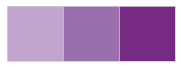

In [4]:
# contour plot colours
# thanks to colorbrewer for these palettes! https://colorbrewer2.org
green        = ['#a6dba0','#5aae61','#1b7837']
purple       = ['#c2a5cf', '#9970ab', '#762a83']
analogous    = ['#a0c3db', '#dbb7a0']
warm         = ['#fdcc8a', '#fc8d59', '#d7301f']
cool         = ['#41b6c4', '#2c7fb8', '#253494']

# have a look at a palette for example
show_palette(purple)

# set the seaborn style
sns.set_style('ticks')

# use TeX for plot labels
rc('text', usetex=True)
rc('font', family='serif')
rcParams.update({'font.size': 18})

### Global MCMC settings

In [5]:
walker_ratio = 10 # number of walkers per parameter
n_burn = 500 # number of burn-in steps
n_run = 2500 # number of sampling steps
sigma_scale = 1e-2

## Create the source <a name="create_source"></a>

[Back to contents](#contents)

In [6]:
# source model
source_model_list = ['SERSIC_ELLIPSE']

magnitude_source = 24.0

R_sersic_source = 0.3 #0.03
n_sersic_source = 1.0

# give the source a little ellipticity
source_orientation = np.random.uniform(0.0, 2.0*np.pi)
source_aspect_ratio = np.random.uniform(0.8, 1.0)

# e1_source, e2_source = ellipticity(source_orientation, source_aspect_ratio)

# x_source, y_source = np.random.uniform(-0.05, 0.05), np.random.uniform(-0.05, 0.05)

e1_source, e2_source = 0.1035668046411672, -0.03853234550643717
x_source, y_source = -0.0029565081421967093, 0.048037680878407304

kwargs_sersic = {'magnitude': magnitude_source,
                 'R_sersic': R_sersic_source, 
                 'n_sersic': n_sersic_source, 
                 'e1': e1_source, 
                 'e2': e2_source, 
                 'center_x': x_source, 
                 'center_y': y_source}

print('\nThe source parameters are', kwargs_sersic)

kwargs_source = [kwargs_sersic]


The source parameters are {'magnitude': 24.0, 'R_sersic': 0.3, 'n_sersic': 1.0, 'e1': 0.1035668046411672, 'e2': -0.03853234550643717, 'center_x': -0.0029565081421967093, 'center_y': 0.048037680878407304}


## Create the lens <a name="create_lens"></a>

[Back to contents](#contents)

In [7]:
lens_model_list = ['LOS', 'EPL']

### Line-of-sight shear

In [8]:
kappa = 0.0
omega = 0.0
# gamma = np.random.uniform(-0.03, 0.03, 6) # get six random shears

gamma = [-0.0027105556771630894, -0.006014494604416134, 
         -0.00914639228059258, -0.028090674808000628,  
         0.019014947157970793, 0.01770838982830792]

In [9]:
kwargs_los = {'gamma1_od': gamma[0], 'gamma2_od': gamma[1], 'kappa_od': kappa, 'omega_od': omega,
              'gamma1_os': gamma[2], 'gamma2_os': gamma[3], 'kappa_os': kappa, 'omega_os': omega,
              'gamma1_ds': gamma[4], 'gamma2_ds': gamma[5], 'kappa_ds': kappa, 'omega_ds': omega}

# compute the expected LOS shear for when we run the minimal model
gamma1_los = kwargs_los['gamma1_od'] + kwargs_los['gamma1_os'] - kwargs_los['gamma1_ds']
gamma2_los = kwargs_los['gamma2_od'] + kwargs_los['gamma2_os'] - kwargs_los['gamma2_ds']

print('\nThe LOS parameters are', kwargs_los)
print('\nThe LOS shears are', (gamma1_los, gamma2_los))


The LOS parameters are {'gamma1_od': -0.0027105556771630894, 'gamma2_od': -0.006014494604416134, 'kappa_od': 0.0, 'omega_od': 0.0, 'gamma1_os': -0.00914639228059258, 'gamma2_os': -0.028090674808000628, 'kappa_os': 0.0, 'omega_os': 0.0, 'gamma1_ds': 0.019014947157970793, 'gamma2_ds': 0.01770838982830792, 'kappa_ds': 0.0, 'omega_ds': 0.0}

The LOS shears are (-0.030871895115726463, -0.05181355924072468)


In [10]:
# effective LOS rotation in minimal model (from the shear-shear couplings)
gamma_od = complex(kwargs_los['gamma1_od'], kwargs_los['gamma2_od'])
gamma_os = complex(kwargs_los['gamma1_os'], kwargs_los['gamma2_os'])
gamma_ds = complex(kwargs_los['gamma1_ds'], kwargs_los['gamma2_ds'])

# Values of the paper
#gamma_od = complex(-0.0027105556771630894, -0.006014494604416134)
#gamma_os = complex(-0.00914639228059258, -0.028090674808000628)
#gamma_ds = complex(0.019014947157970793, 0.01770838982830792)

omega_LOS = (gamma_ds * gamma_os.conjugate()
            - gamma_od * gamma_os.conjugate()
            + gamma_od * gamma_ds.conjugate()
            ).imag / (1 - gamma_ds * gamma_ds.conjugate())

print('The effective LOS rotation is', omega_LOS)

The effective LOS rotation is (0.0003271603916985856+0j)


### Elliptical power law

In [11]:
theta_E = 1.2 # arcsec

# set the slope of the power law t = gamma - 1
# t should be between 0 and 2 (1507.01819) i.e. 1 < gamma < 3
# when t = 1, EPL -> SIS; when t = 2, EPL -> point mass
gamma_epl = 2.6

# set the location of the centre of the profile
# x_epl, y_epl = np.random.uniform(-0.05, 0.05), np.random.uniform(-0.05, 0.05)

x_epl, y_epl = 0.01375733042132142, -0.04843290832903803

# set the ellipticity
orientation_angle_epl = np.random.uniform(0.0, 2*np.pi)
aspect_ratio_epl = np.random.uniform(0.8, 1.0)

# e1_epl, e2_epl = ellipticity(orientation_angle_epl, aspect_ratio_epl)

e1_epl, e2_epl = -0.05326771893418661, -0.07678639472464893

# set the kwargs for the lenstronomy Profile
kwargs_epl = {'theta_E': theta_E,
              'gamma': gamma_epl,
              'center_x': x_epl,
              'center_y': y_epl,
              'e1': e1_epl,
              'e2': e2_epl}

print('\nThe EPL parameters are', kwargs_epl)


The EPL parameters are {'theta_E': 1.2, 'gamma': 2.6, 'center_x': 0.01375733042132142, 'center_y': -0.04843290832903803, 'e1': -0.05326771893418661, 'e2': -0.07678639472464893}


### Add lens light

In [12]:
lens_light_model_list = ['SERSIC_ELLIPSE']

magnitude_lens_light = 20.0

R_sersic_lens_light = 0.5 #0.05
n_sersic_lens_light = 4.0

# give the light the same centre and ellipticity as the lens
kwargs_sersic_lens = {'magnitude': magnitude_lens_light,
                     'R_sersic': R_sersic_lens_light, 
                     'n_sersic': n_sersic_lens_light, 
                     'e1': e1_epl, 
                     'e2': e2_epl, 
                     'center_x': x_epl, 
                     'center_y': y_epl}

kwargs_lens_light = [kwargs_sersic_lens]

print('\nThe lens light parameters are', kwargs_sersic_lens)


The lens light parameters are {'magnitude': 20.0, 'R_sersic': 0.5, 'n_sersic': 4.0, 'e1': -0.05326771893418661, 'e2': -0.07678639472464893, 'center_x': 0.01375733042132142, 'center_y': -0.04843290832903803}


### Gather the lens model

In [13]:
kwargs_lens = [kwargs_los, kwargs_epl]

kwargs_model = {'lens_model_list': lens_model_list,
                'lens_light_model_list': lens_light_model_list,
                'source_light_model_list': source_model_list}

## Create the image <a name="create_image"></a>

[Back to contents](#contents)

In [14]:
# get the telescope settings for HST
psf = 'GAUSSIAN'
band = HST(band='WFC3_F160W', psf_type=psf) # this chooses the specific camera and filter of HST
kwargs_band = band.kwargs_single_band() # we are only considering a single band (i.e. a single wavelength/filter)
pixel_size = band.camera['pixel_scale'] # in arcsec

kwargs_psf = {'psf_type': psf,
              'fwhm': kwargs_band['seeing'],
              'pixel_size': pixel_size,
              'truncation': 3}

# define the numerics
kwargs_numerics = {'supersampling_factor': 1,
                   'supersampling_convolution': False}

# call the simulation API class
sim = SimAPI(numpix = 49, # number of pixels we want in our image
             kwargs_single_band = kwargs_band, # give the SimAPI class the keyword arguments for HST that we got above
             kwargs_model = kwargs_model)

kwargs_data = sim.kwargs_data

In [15]:
# convert magnitudes into amplitudes
# we don't care about point source
kwargs_lens_light, kwargs_source, ps = sim.magnitude2amplitude(kwargs_lens_light_mag=kwargs_lens_light,
                                                               kwargs_source_mag=kwargs_source)

In [16]:
# now use the SimAPI class to generate a noisy image in one step
imSim = sim.image_model_class(kwargs_numerics)

image = imSim.image(kwargs_lens = kwargs_lens,
                    kwargs_source = kwargs_source,
                    kwargs_lens_light=kwargs_lens_light)

image_noisy = image + sim.noise_for_model(model = image)

kwargs_data['image_data'] = image_noisy

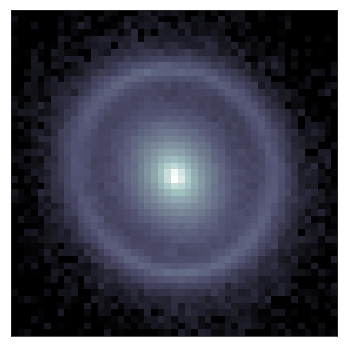

In [17]:
# plot the image
cmap_string = 'bone'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -2
v_max = 1

f, ax = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
im = ax.matshow(np.log10(image_noisy), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

plt.savefig(outpath+'advantage_image.pdf', dpi=300, bbox_inches='tight')

plt.show()

## Fit the image  <a name="analyse_image"></a>

[Back to contents](#contents)

### Full LOS model

In [18]:
# LENS MODEL

lens_model_list = ['LOS', 'EPL']

# Initialise the lists of parameters
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

# Parameters for the lens 
# Specify which parameters are fixed and, for the parameters that will be
# explored, choose their initial value, step size, lower and higher limits

# Line-of-sight parameters
fixed_lens.append({'kappa_od': 0.0, 'kappa_os': 0.0, 'kappa_ds': 0.0, 
                   'omega_od': 0.0, 'omega_os':0.0, 'omega_ds': 0.0})

params = ['gamma1_od', 'gamma2_od',
          'gamma1_os', 'gamma2_os',
          'gamma1_ds', 'gamma2_ds'] 

kwargs_lens_init.append({'gamma1_od': kwargs_los['gamma1_od'],
                         'gamma2_od': kwargs_los['gamma2_od'],
                         'gamma1_os': kwargs_los['gamma1_os'],
                         'gamma2_os': kwargs_los['gamma2_os'],
                         'gamma1_ds': kwargs_los['gamma1_ds'],
                         'gamma2_ds': kwargs_los['gamma2_ds']})

kwargs_lens_sigma.append({param: 0.1 for param in params})
kwargs_lower_lens.append({param: -0.5 for param in params})
kwargs_upper_lens.append({param: 0.5 for param in params})

# EPL
fixed_lens.append({'center_x': x_epl, 'center_y': y_epl})
kwargs_lens_init.append({'theta_E': theta_E, 'gamma': gamma_epl, 'e1': e1_epl, 'e2': e2_epl})
kwargs_lens_sigma.append({'theta_E': 0.1, 'gamma': 0.1, 'e1': 0.1, 'e2': 0.1})
kwargs_lower_lens.append({'theta_E': 0.01, 'gamma': 0.0, 'e1': -0.5, 'e2': -0.5})
kwargs_upper_lens.append({'theta_E': 10.0, 'gamma': 4.0, 'e1': 0.5, 'e2': 0.5})

lens_params = [kwargs_lens_init,
               kwargs_lens_sigma,
               fixed_lens,
               kwargs_lower_lens,
               kwargs_upper_lens]

# SOURCE MODEL

source_model_list = ['SERSIC_ELLIPSE']

# Initialise the lists of parameters
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []


# Define parameters
fixed_source.append({})
kwargs_source_init.append({'center_x': x_source,
                           'center_y': y_source,
                           'R_sersic': R_sersic_source, 
                           'n_sersic': n_sersic_source, 
                           'e1': e1_source, 
                           'e2': e2_source})
kwargs_source_sigma.append({'center_x': 0.1, 'center_y': 0.1,
                            'R_sersic': 0.1, 'n_sersic': 0.1,
                            'e1': 0.1, 'e2': 0.1})
kwargs_lower_source.append({'center_x': -0.1, 'center_y': -0.1,
                            'R_sersic': 0.0, 'n_sersic': 0.0,
                            'e1': -0.5, 'e2': -0.5})
kwargs_upper_source.append({'center_x': 0.1, 'center_y': 0.1,
                            'R_sersic': 10.0, 'n_sersic': 6.0,
                            'e1': 0.5, 'e2': 0.5})

source_params = [kwargs_source_init, kwargs_source_sigma,
                 fixed_source, kwargs_lower_source, kwargs_upper_source]


# lens light model
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

# Define parameters
fixed_lens_light.append({'center_x': x_epl, 'center_y': y_epl})
kwargs_lens_light_init.append({'R_sersic': R_sersic_lens_light, 
                               'n_sersic': n_sersic_lens_light, 
                               'e1': e1_epl, 
                               'e2': e2_epl}) 

kwargs_lens_light_sigma.append({'R_sersic': 0.1, 'n_sersic': 0.1, 'e1': 0.1, 'e2': 0.1})
kwargs_lower_lens_light.append({'R_sersic': 0.0, 'n_sersic': 0.0, 'e1': -0.5, 'e2': -0.5})
kwargs_upper_lens_light.append({'R_sersic': 10.0, 'n_sersic': 6.0, 'e1': 0.5,  'e2': 0.5})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma,
                    fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]


kwargs_params = {'lens_model': lens_params,
                 'source_model': source_params,
                 'lens_light_model': lens_light_params}

In [19]:
# run the MCMC
kwargs_likelihood = {'source_marg': True}

kwargs_model = {'lens_model_list': lens_model_list,
                'source_light_model_list': source_model_list,
                'lens_light_model_list': lens_light_model_list}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]
kwargs_data_joint = {'multi_band_list': multi_band_list,
                     'multi_band_type': 'multi-linear'}
kwargs_constraints = {}

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, 
                              kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['MCMC',
                        {'n_burn': n_burn, 
                         'n_run': n_run,
                         'walkerRatio': walker_ratio, 
                         'sigma_scale': sigma_scale, 
                         #'threadCount': ncpu,
                         'backend_filename': outpath + 'chains/full.h5'}]]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

print("""Best-fit parameters:
{}
""".format(kwargs_result))

100%|██████████| 3000/3000 [53:51<00:00,  1.08s/it] 

Computing the MCMC...
Number of walkers =  200
Burn-in iterations:  500
Sampling iterations (in current run): 3000
3232.5272300243378 time taken for MCMC sampling
Best-fit parameters:
{'kwargs_lens': [{'kappa_od': 0.0, 'kappa_os': 0.0, 'kappa_ds': 0.0, 'gamma1_od': -0.029688803238982257, 'gamma2_od': -0.029867840248693732, 'gamma1_os': -0.004538010955813524, 'gamma2_os': 0.19390662633568773, 'gamma1_ds': -0.0010513897636390407, 'gamma2_ds': 0.21442023304232755, 'omega_od': 0.0, 'omega_os': 0.0, 'omega_ds': 0.0}, {'theta_E': 1.2036139173982876, 'gamma': 2.568308333613628, 'e1': 0.09428066175493408, 'e2': 0.06369125065588564, 'center_x': 0.01375733042132142, 'center_y': -0.04843290832903803}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.28697093458353046, 'n_sersic': 1.0228938100089415, 'e1': 0.09948212191466207, 'e2': -0.2439708440623734, 'center_x': -0.014029319095218293, 'center_y': 0.04930167027229198}], 'kwargs_lens_light': [{'amp': 1, 'R_sersic': 0.505134644658071, 'n_sersic': 4.024

-0.9803451418916531 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.9803451418916531


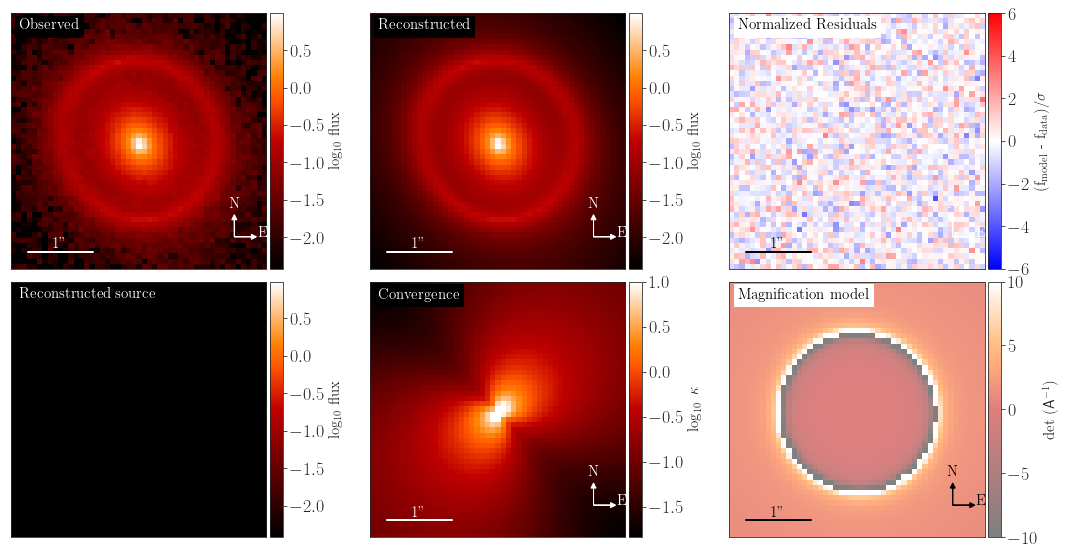

In [20]:
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result,
                      arrow_size=0.02, cmap_string="gist_heat")
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)

plt.savefig(outpath+'reconstruction_full.pdf', dpi=300, bbox_inches='tight')

plt.show()

number of non-linear parameters in the MCMC process:  20
parameters in order:  ['gamma1_od_lens0', 'gamma2_od_lens0', 'gamma1_os_lens0', 'gamma2_os_lens0', 'gamma1_ds_lens0', 'gamma2_ds_lens0', 'theta_E_lens1', 'gamma_lens1', 'e1_lens1', 'e2_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0']
number of evaluations in the MCMC process:  500000


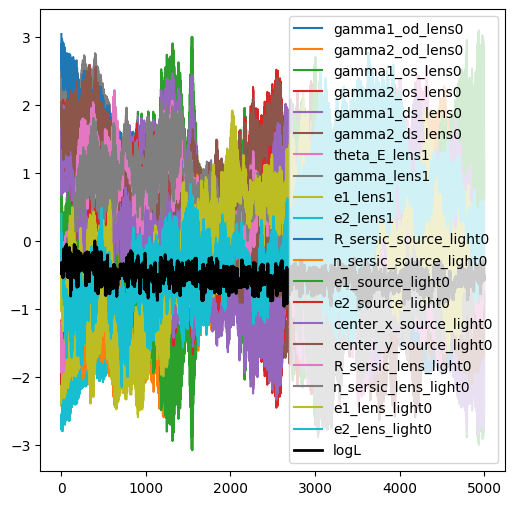

In [21]:
# Convergence of the MCMC
rcParams.update(rcParamsDefault)

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)
    
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[0]

print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])

In [22]:
# Constraints on the parameters: define the labels and expected values

labels = [# LOS
          r'$\gamma^{\rm od}_1$',
          r'$\gamma^{\rm od}_2$',
          r'$\gamma^{\rm os}_1$',
          r'$\gamma^{\rm os}_2$',
          r'$\gamma^{\rm ds}_1$',
          r'$\gamma^{\rm ds}_2$',
          # EPL
          r'$\theta_{\rm E}$',
          r'$\gamma_{\rm EPL}$',
          r'$e_{1, \rm EPL}$',
          r'$e_{2, \rm EPL}$',
          # source
          r'$R_{\rm Sérsic}$',
          r'$n_{\rm Sérsic}$',
          r'$e_1^{\rm source}$',
          r'$e_2^{\rm source}$',
          # lens light
          r'$R_{\rm Sérsic, l}$',
          r'$n_{\rm Sérsic, l}$',
          r'$e_1^{\rm lens}$',
          r'$e_2^{\rm lens}$']

expected_values = [# LOS
                   kwargs_los['gamma1_od'],
                   kwargs_los['gamma2_od'],
                   kwargs_los['gamma1_os'],
                   kwargs_los['gamma2_os'],
                   kwargs_los['gamma1_ds'],
                   kwargs_los['gamma2_ds'],
                   # EPL
                   kwargs_epl['theta_E'],
                   kwargs_epl['gamma'],
                   kwargs_epl['e1'],
                   kwargs_epl['e2'],
                   # source
                   kwargs_sersic['R_sersic'],
                   kwargs_sersic['n_sersic'],
                   kwargs_sersic['e1'],
                   kwargs_sersic['e2'],
                   # lens light
                   kwargs_sersic_lens['R_sersic'],
                   kwargs_sersic_lens['n_sersic'],
                   kwargs_sersic_lens['e1'],
                   kwargs_sersic_lens['e2']]

n, num_param = np.shape(samples_mcmc)

In [23]:
print(samples_mcmc)

[[-9.97247327e-03 -1.39680861e-02  2.87110087e-02 ...  4.02073435e+00
  -5.12964965e-02 -7.81617540e-02]
 [ 5.42529803e-03  2.15426072e-03  6.94832924e-02 ...  4.03591031e+00
  -5.36032277e-02 -7.89168276e-02]
 [-5.69287955e-03 -1.30991788e-02 -5.23599728e-02 ...  4.03854711e+00
  -5.38717244e-02 -7.66611648e-02]
 ...
 [-1.97400347e-02 -3.81999986e-02 -1.07806376e-01 ...  4.02675074e+00
  -5.23233724e-02 -7.67770587e-02]
 [-3.50546214e-02 -2.41021265e-02 -1.09766061e-02 ...  4.00599427e+00
  -5.19825556e-02 -7.74367483e-02]
 [-2.24362004e-02 -4.00577355e-02  1.53822904e-01 ...  3.98776142e+00
  -4.98721021e-02 -7.88170479e-02]]


### Contour plot

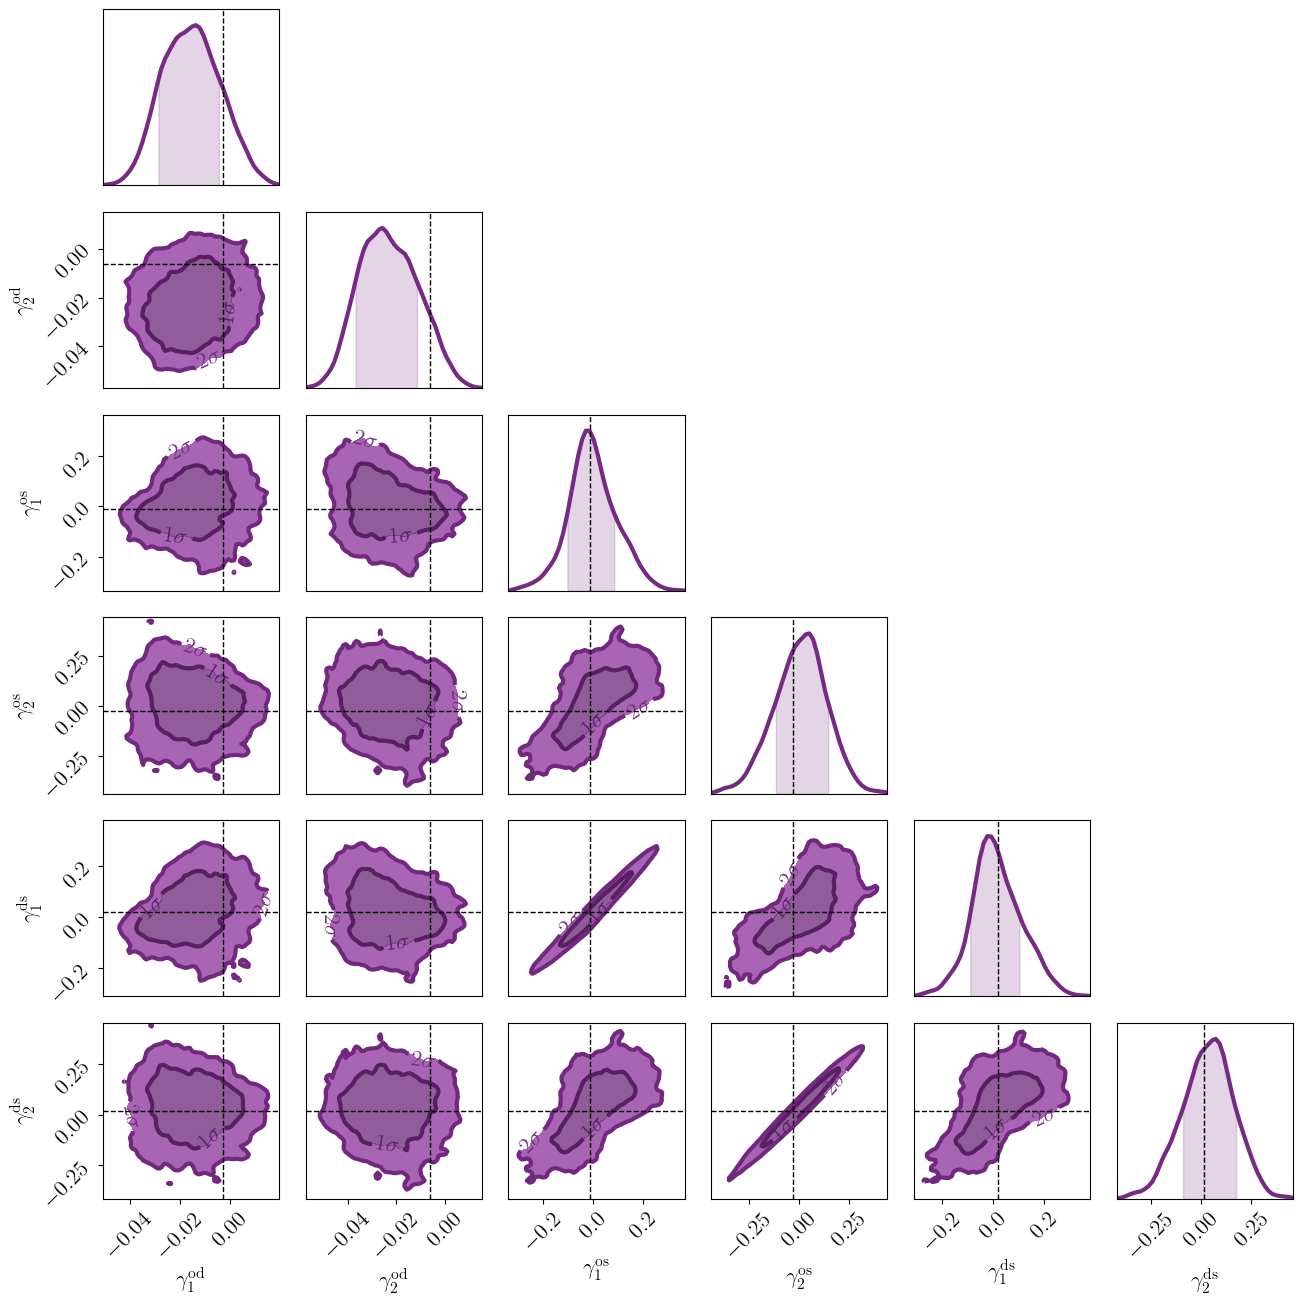

Gelman-Rubin Statistic values for chain Chain 0
$\gamma^{\rm od}_1$: 1.03113 (Passed)
$\gamma^{\rm od}_2$: 1.05090 (Failed)
$\gamma^{\rm os}_1$: 1.00090 (Passed)
$\gamma^{\rm os}_2$: 1.00051 (Passed)
$\gamma^{\rm ds}_1$: 1.00217 (Passed)
$\gamma^{\rm ds}_2$: 1.00040 (Passed)
False


In [24]:
c = ChainConsumer()

n_walkers = len(param_mcmc)*walker_ratio

c.add_chain(samples_mcmc[:,0:6], walkers = n_walkers, parameters = labels[0:6])

fontsize = 16

c.configure(smooth = True, flip = False, summary = False, 
            spacing = 3.0, max_ticks = 4,
            colors = purple[2], shade = True, shade_gradient = 0.4, 
            bar_shade = True, linewidths= [3.0],
            tick_font_size=fontsize, label_font_size=fontsize, 
            usetex = True, serif = True,
            contour_labels = 'sigma', contour_label_font_size = fontsize)

fig = c.plotter.plot(truth=expected_values[0:6], figsize = (14,14))

fig.patch.set_facecolor('white')

plt.savefig(outpath+'contours_full.pdf', dpi=300, bbox_inches='tight')

plt.show()

gelman_rubin_converged = c.diagnostic.gelman_rubin() # does this make sense for emcee chains??
print(gelman_rubin_converged)

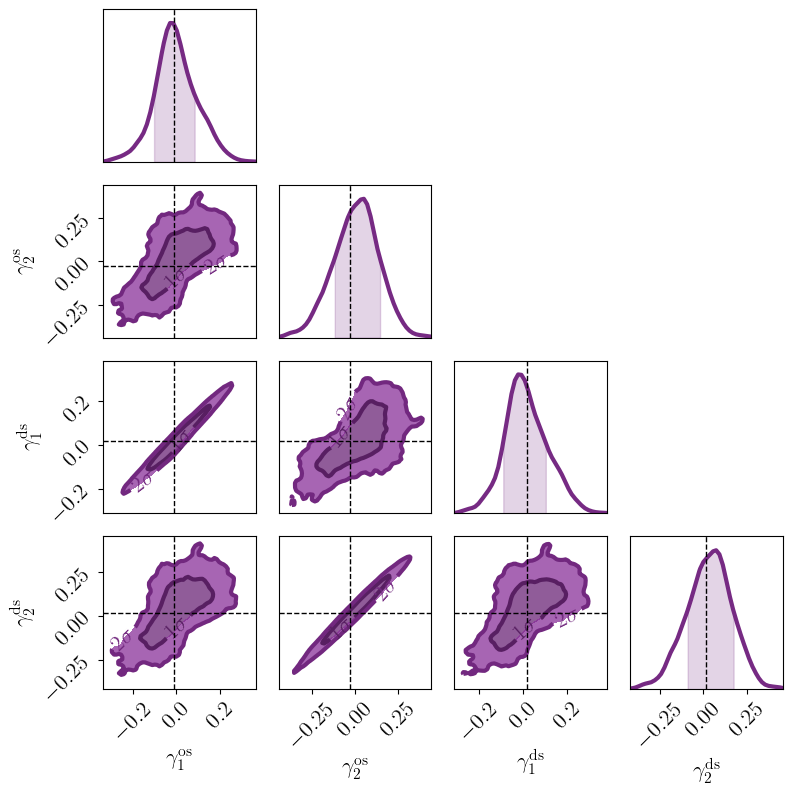

Gelman-Rubin Statistic values for chain Chain 0
$\gamma^{\rm os}_1$: 1.00090 (Passed)
$\gamma^{\rm os}_2$: 1.00051 (Passed)
$\gamma^{\rm ds}_1$: 1.00217 (Passed)
$\gamma^{\rm ds}_2$: 1.00040 (Passed)
True


In [25]:
c = ChainConsumer()

n_walkers = len(param_mcmc)*walker_ratio

c.add_chain(samples_mcmc[:,2:6], walkers = n_walkers, parameters = labels[2:6])

fontsize = 16

c.configure(smooth = True, flip = False, summary = False, 
            spacing = 3.0, max_ticks = 4,
            colors = purple[2], shade = True, shade_gradient = 0.4, 
            bar_shade = True, linewidths= [3.0],
            tick_font_size=fontsize, label_font_size=fontsize, 
            usetex = True, serif = True,
            contour_labels = 'sigma', contour_label_font_size = fontsize)

fig = c.plotter.plot(truth=expected_values[2:6], figsize = (8,8))

fig.patch.set_facecolor('white')

plt.savefig(outpath+'contours_full_shears.pdf', dpi=300, bbox_inches='tight')

plt.show()

gelman_rubin_converged = c.diagnostic.gelman_rubin() # does this make sense for emcee chains??
print(gelman_rubin_converged)

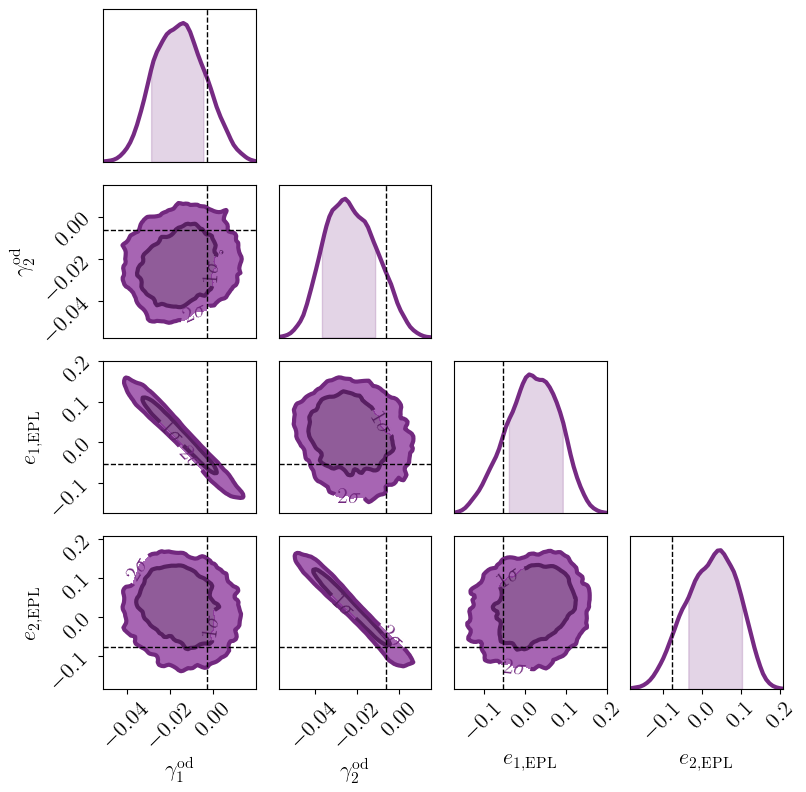

Gelman-Rubin Statistic values for chain Chain 0
$\gamma^{\rm od}_1$: 1.03113 (Passed)
$\gamma^{\rm od}_2$: 1.05090 (Failed)
$e_{1, \rm EPL}$: 1.02743 (Passed)
$e_{2, \rm EPL}$: 1.05015 (Failed)
False


In [26]:
c = ChainConsumer()

n_walkers = len(param_mcmc)*walker_ratio

my_inds = [0,1,8,9]

fontsize = 16

c.add_chain([samples_mcmc[:,ind] for ind in my_inds], 
            walkers = n_walkers, 
            parameters = [labels[ind] for ind in my_inds])

c.configure(smooth = True, flip = False, summary = False, 
            spacing = 3.0, max_ticks = 4,
            colors = purple[2], shade = True, shade_gradient = 0.4, 
            bar_shade = True, linewidths= [3.0],
            tick_font_size=fontsize, label_font_size=fontsize, 
            usetex = True, serif = True,
            contour_labels = 'sigma', contour_label_font_size = fontsize)

fig = c.plotter.plot(truth=[expected_values[ind] for ind in my_inds], figsize = (8,8))

fig.patch.set_facecolor('white')

plt.savefig(outpath+'contours_full_ellipticity.pdf', dpi=300, bbox_inches='tight')

plt.show()

gelman_rubin_converged = c.diagnostic.gelman_rubin() # does this make sense for emcee chains??
print(gelman_rubin_converged)

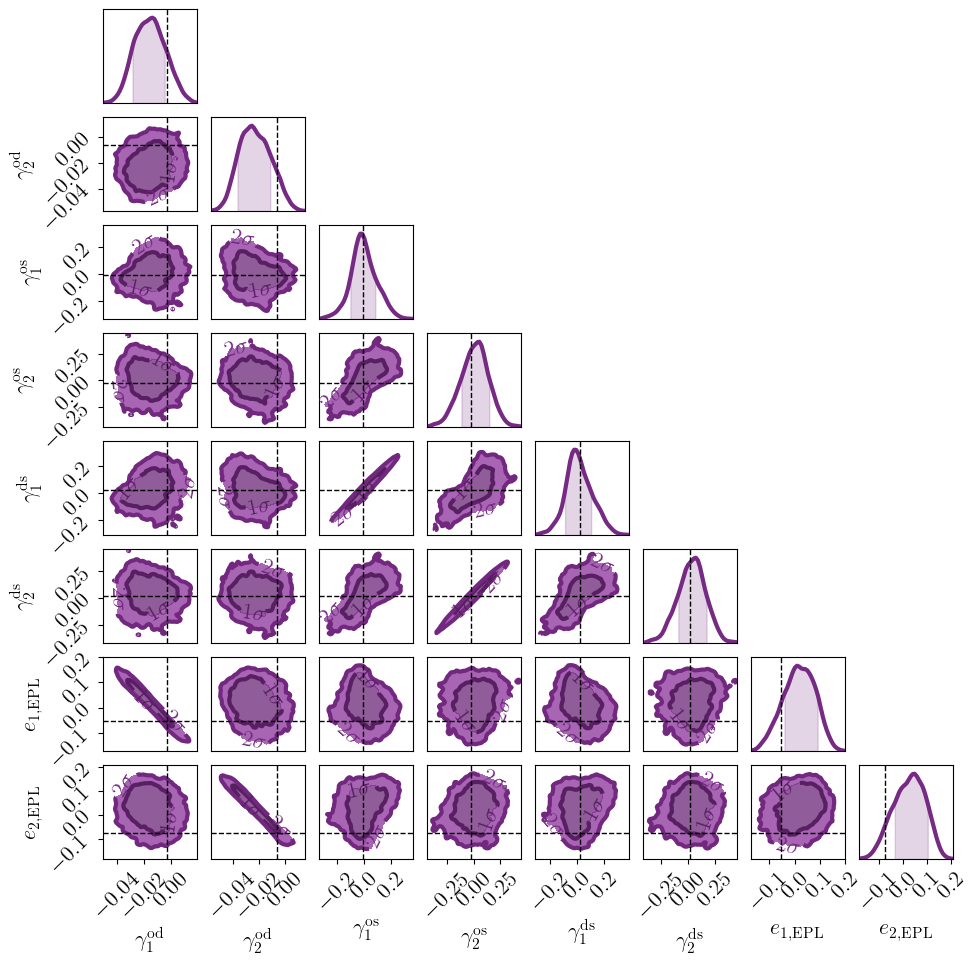

Gelman-Rubin Statistic values for chain Chain 0
$\gamma^{\rm od}_1$: 1.03113 (Passed)
$\gamma^{\rm od}_2$: 1.05090 (Failed)
$\gamma^{\rm os}_1$: 1.00090 (Passed)
$\gamma^{\rm os}_2$: 1.00051 (Passed)
$\gamma^{\rm ds}_1$: 1.00217 (Passed)
$\gamma^{\rm ds}_2$: 1.00040 (Passed)
$e_{1, \rm EPL}$: 1.02743 (Passed)
$e_{2, \rm EPL}$: 1.05015 (Failed)
False


In [27]:
c = ChainConsumer()

n_walkers = len(param_mcmc)*walker_ratio

my_inds = [0,1,2,3,4,5,8,9]

fontsize = 16

c.add_chain([samples_mcmc[:,ind] for ind in my_inds], 
            walkers = n_walkers, 
            parameters = [labels[ind] for ind in my_inds])

c.configure(smooth = True, flip = False, summary = False, 
            spacing = 3.0, max_ticks = 4,
            colors = purple[2], shade = True, shade_gradient = 0.4, 
            bar_shade = True, linewidths= [3.0],
            tick_font_size=fontsize, label_font_size=fontsize, 
            usetex = True, serif = True,
            contour_labels = 'sigma', contour_label_font_size = fontsize)

fig = c.plotter.plot(truth=[expected_values[ind] for ind in my_inds], figsize = (10,10))

fig.patch.set_facecolor('white')

plt.savefig(outpath+'contours_full_all.pdf', dpi=300, bbox_inches='tight')

plt.show()

gelman_rubin_converged = c.diagnostic.gelman_rubin() # does this make sense for emcee chains??
print(gelman_rubin_converged)

### Minimal LOS model <a name="fit_zero"></a>

In [28]:
# LENS MODEL

lens_model_list = ['LOS_MINIMAL', 'EPL']

# Initialise the lists of parameters
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

# Parameters for the lens 
# Specify which parameters are fixed and, for the parameters that will be
# explored, choose their initial value, step size, lower and higher limits

# Line-of-sight parameters
fixed_lens.append({'kappa_od': 0.0, 'kappa_los': 0.0, 'omega_od': 0.0})

params = ['gamma1_od', 'gamma2_od',
          'gamma1_los', 'gamma2_los',
          'omega_los'] 

kwargs_lens_init.append({'gamma1_od': kwargs_los['gamma1_od'],
                         'gamma2_od': kwargs_los['gamma2_od'],
                         'gamma1_los': gamma1_los,
                         'gamma2_los': gamma2_los,
                         'omega_los': omega})

kwargs_lens_sigma.append({param: 0.1 for param in params})
kwargs_lower_lens.append({param: -0.5 for param in params})
kwargs_upper_lens.append({param: 0.5 for param in params})

# EPL
fixed_lens.append({'center_x': x_epl, 'center_y': y_epl})
kwargs_lens_init.append({'theta_E': theta_E, 'gamma': gamma_epl, 'e1': e1_epl, 'e2': e2_epl})
kwargs_lens_sigma.append({'theta_E': 0.1, 'gamma': 0.1, 'e1': 0.1, 'e2': 0.1})
kwargs_lower_lens.append({'theta_E': 0.01, 'gamma': 0.0, 'e1': -0.5, 'e2': -0.5})
kwargs_upper_lens.append({'theta_E': 10.0, 'gamma': 4.0, 'e1': 0.5, 'e2': 0.5})

lens_params = [kwargs_lens_init,
               kwargs_lens_sigma,
               fixed_lens,
               kwargs_lower_lens,
               kwargs_upper_lens]

# SOURCE MODEL

source_model_list = ['SERSIC_ELLIPSE']

# Initialise the lists of parameters
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []


# Define parameters
fixed_source.append({})
kwargs_source_init.append({'center_x': x_source,
                           'center_y': y_source,
                           'R_sersic': R_sersic_source, 
                           'n_sersic': n_sersic_source, 
                           'e1': e1_source, 
                           'e2': e2_source})
kwargs_source_sigma.append({'center_x': 0.1, 'center_y': 0.1,
                            'R_sersic': 0.1, 'n_sersic': 0.1,
                            'e1': 0.1, 'e2': 0.1})
kwargs_lower_source.append({'center_x': -0.1, 'center_y': -0.1,
                            'R_sersic': 0.0, 'n_sersic': 0.0,
                            'e1': -0.5, 'e2': -0.5})
kwargs_upper_source.append({'center_x': 0.1, 'center_y': 0.1,
                            'R_sersic': 10.0, 'n_sersic': 5.0,
                            'e1': 0.5, 'e2': 0.5})

source_params = [kwargs_source_init, kwargs_source_sigma,
                 fixed_source, kwargs_lower_source, kwargs_upper_source]


# lens light model
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

# Define parameters
fixed_lens_light.append({'center_x': x_epl, 'center_y': y_epl})
kwargs_lens_light_init.append({'R_sersic': R_sersic_lens_light, 
                               'n_sersic': n_sersic_lens_light, 
                               'e1': e1_epl, 
                               'e2': e2_epl}) 

kwargs_lens_light_sigma.append({'R_sersic': 0.1, 'n_sersic': 0.1, 'e1': 0.1, 'e2': 0.1})
kwargs_lower_lens_light.append({'R_sersic': -10.0, 'n_sersic': 0.0,   'e1': -0.5, 'e2': -0.5})
kwargs_upper_lens_light.append({'R_sersic': 10.0,  'n_sersic': 5.0,   'e1': 0.5,  'e2': 0.5})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma,
                    fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

kwargs_params = {'lens_model': lens_params,
                 'source_model': source_params,
                 'lens_light_model': lens_light_params}

In [29]:
kwargs_likelihood = {'source_marg': True}

kwargs_model = {'lens_model_list': lens_model_list,
                'source_light_model_list': source_model_list,
                'lens_light_model_list': lens_light_model_list}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]
kwargs_data_joint = {'multi_band_list': multi_band_list,
                     'multi_band_type': 'multi-linear'}
kwargs_constraints = {}

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, 
                              kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['MCMC',
                        {'n_burn': n_burn, 
                         'n_run': n_run,
                         'walkerRatio': walker_ratio, 
                         'sigma_scale': sigma_scale,
                         #'threadCount': ncpu,
                         'backend_filename': outpath + 'chains/minimal.h5'}]]

chain_list_min = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result_min = fitting_seq.best_fit()

print("""Best-fit parameters:
{}
""".format(kwargs_result))

INFO:lenstronomy.Sampling.Pool.pool:Running with SerialPool


100%|██████████| 3000/3000 [48:50<00:00,  1.02it/s] 

Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  500
Sampling iterations (in current run): 3000
2932.052349090576 time taken for MCMC sampling
Best-fit parameters:
{'kwargs_lens': [{'kappa_od': 0.0, 'kappa_os': 0.0, 'kappa_ds': 0.0, 'gamma1_od': -0.029688803238982257, 'gamma2_od': -0.029867840248693732, 'gamma1_os': -0.004538010955813524, 'gamma2_os': 0.19390662633568773, 'gamma1_ds': -0.0010513897636390407, 'gamma2_ds': 0.21442023304232755, 'omega_od': 0.0, 'omega_os': 0.0, 'omega_ds': 0.0}, {'theta_E': 1.2036139173982876, 'gamma': 2.568308333613628, 'e1': 0.09428066175493408, 'e2': 0.06369125065588564, 'center_x': 0.01375733042132142, 'center_y': -0.04843290832903803}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.28697093458353046, 'n_sersic': 1.0228938100089415, 'e1': 0.09948212191466207, 'e2': -0.2439708440623734, 'center_x': -0.014029319095218293, 'center_y': 0.04930167027229198}], 'kwargs_lens_light': [{'amp': 1, 'R_sersic': 0.505134644658071, 'n_sersic': 4.0243

-0.9799650459106011 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.9799650459106011


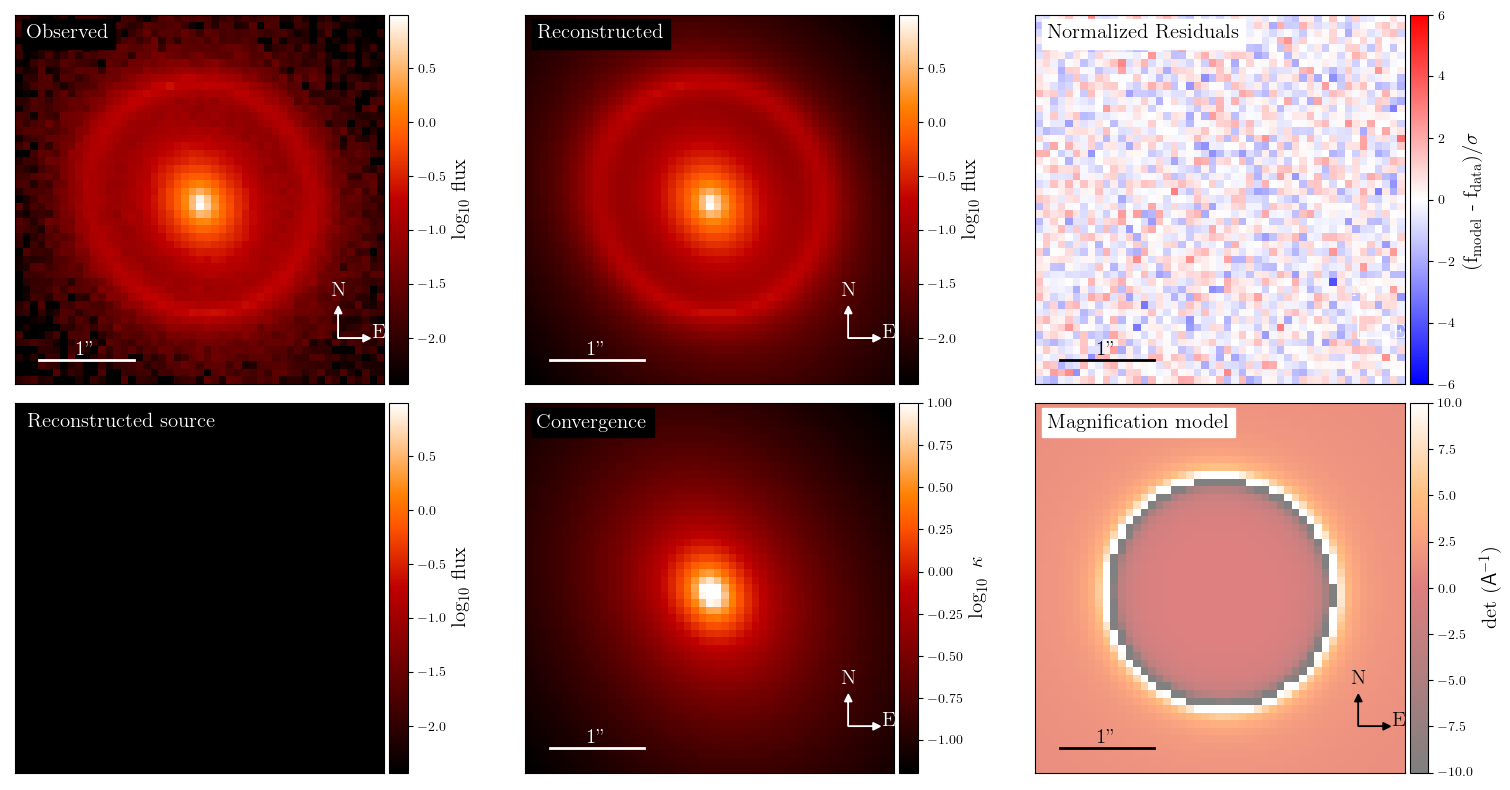

In [30]:
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result_min,
                      arrow_size=0.02, cmap_string="gist_heat")
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)

plt.savefig(outpath+'reconstruction_minimal.pdf', dpi=300, bbox_inches='tight')

plt.show()

number of non-linear parameters in the MCMC process:  19
parameters in order:  ['gamma1_od_lens0', 'gamma2_od_lens0', 'gamma1_los_lens0', 'gamma2_los_lens0', 'omega_los_lens0', 'theta_E_lens1', 'gamma_lens1', 'e1_lens1', 'e2_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0']
number of evaluations in the MCMC process:  475000


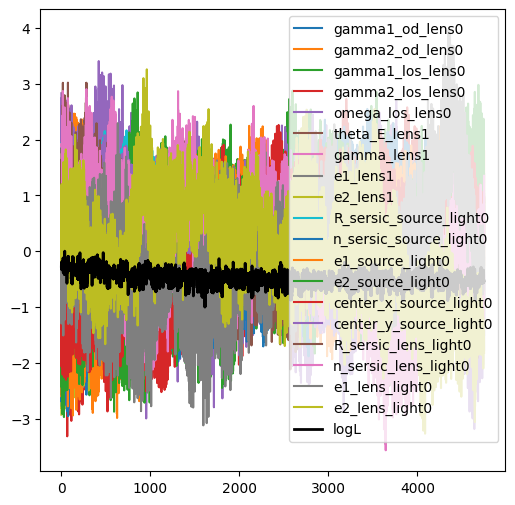

In [31]:
rcParams.update(rcParamsDefault)

for i in range(len(chain_list_min)):
    chain_plot.plot_chain_list(chain_list_min, i)
    
sampler_type, samples_mcmc_min, param_mcmc_min, dist_mcmc  = chain_list_min[0]

print("number of non-linear parameters in the MCMC process: ", len(param_mcmc_min))
print("parameters in order: ", param_mcmc_min)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc_min)[0])

In [32]:
# Constraints on the parameters: define the labels and expected values

labels_min = [# LOS
          r'$\gamma^{\rm od}_1$',
          r'$\gamma^{\rm od}_2$',
          r'$\gamma^{\rm LOS}_1$',
          r'$\gamma^{\rm LOS}_2$',
          r'$\omega^{\rm LOS}$',
          # EPL
          r'$\theta_{\rm E}$',
          r'$\gamma_{\rm EPL}$',
          r'$e_{1, \rm EPL}$',
          r'$e_{2, \rm EPL}$',
          # source
          r'$R_{\rm Sersic}$',
          r'$n_{\rm Sersic}$',
          r'$e_1^{\rm source}$',
          r'$e_2^{\rm source}$',
          # lens light
          r'$R_{\rm Sersic, l}$',
          r'$n_{\rm Sersic, l}$',
          r'$e_1^{\rm lens}$',
          r'$e_2^{\rm lens}$']

expected_values_min = [# LOS
                   kwargs_los['gamma1_od'],
                   kwargs_los['gamma2_od'],
                   gamma1_los,
                   gamma2_los,
                   omega,
                   # EPL
                   kwargs_epl['theta_E'],
                   kwargs_epl['gamma'],
                   kwargs_epl['e1'],
                   kwargs_epl['e2'],
                   # source
                   kwargs_sersic['R_sersic'],
                   kwargs_sersic['n_sersic'],
                   kwargs_sersic['e1'],
                   kwargs_sersic['e2'],
                   # lens light
                   kwargs_sersic_lens['R_sersic'],
                   kwargs_sersic_lens['n_sersic'],
                   kwargs_sersic_lens['e1'],
                   kwargs_sersic_lens['e2']]

n_min, num_param_min = np.shape(samples_mcmc_min)

### Contour plot <a name="contour_zero"></a>

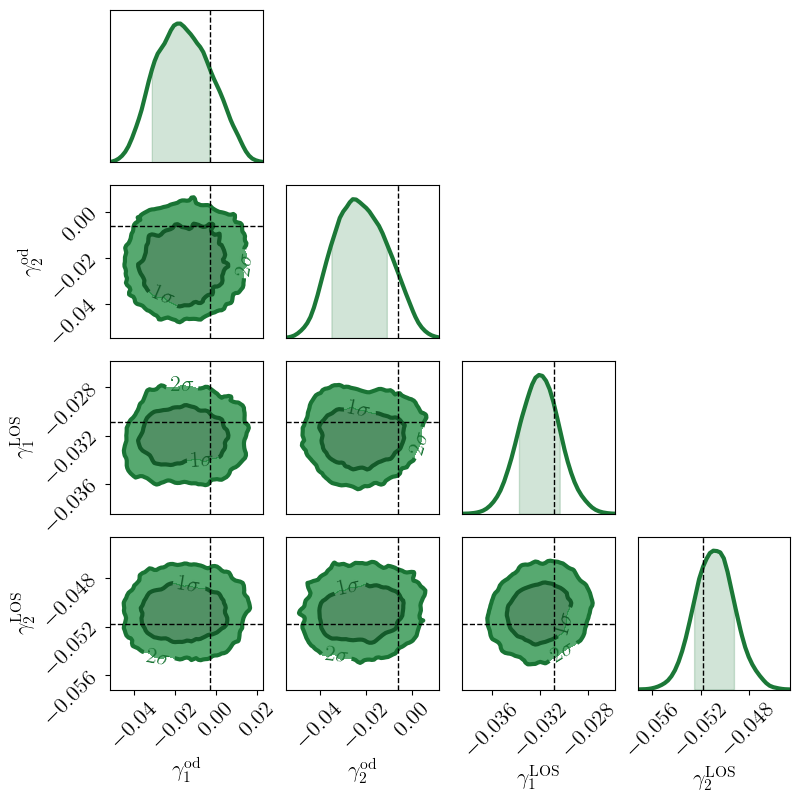

Gelman-Rubin Statistic values for chain Chain 0
$\gamma^{\rm od}_1$: 1.04095 (Passed)
$\gamma^{\rm od}_2$: 1.05428 (Failed)
$\gamma^{\rm LOS}_1$: 1.00185 (Passed)
$\gamma^{\rm LOS}_2$: 1.00404 (Passed)
False


In [33]:
c = ChainConsumer()

n_walkers_min = len(param_mcmc_min)*walker_ratio

fontsize = 16

c.add_chain(samples_mcmc_min[:,0:4], walkers = n_walkers_min, parameters = labels_min[0:4])

c.configure(smooth = True, flip = False, summary = False, 
            spacing = 3.0, max_ticks = 4,
            colors = green[2], shade = True, shade_gradient = 0.4, 
            bar_shade = True, linewidths= [3.0],
            tick_font_size=fontsize, label_font_size=fontsize, 
            usetex = True, serif = True,
            contour_labels = 'sigma', contour_label_font_size = fontsize)

fig = c.plotter.plot(truth=expected_values_min[0:4], figsize = (8,8))

fig.patch.set_facecolor('white')

# plt.savefig(outpath+'contours_minimal.pdf', dpi=300, bbox_inches='tight')

plt.show()

gelman_rubin_converged = c.diagnostic.gelman_rubin() # does this make sense for emcee chains??
print(gelman_rubin_converged)

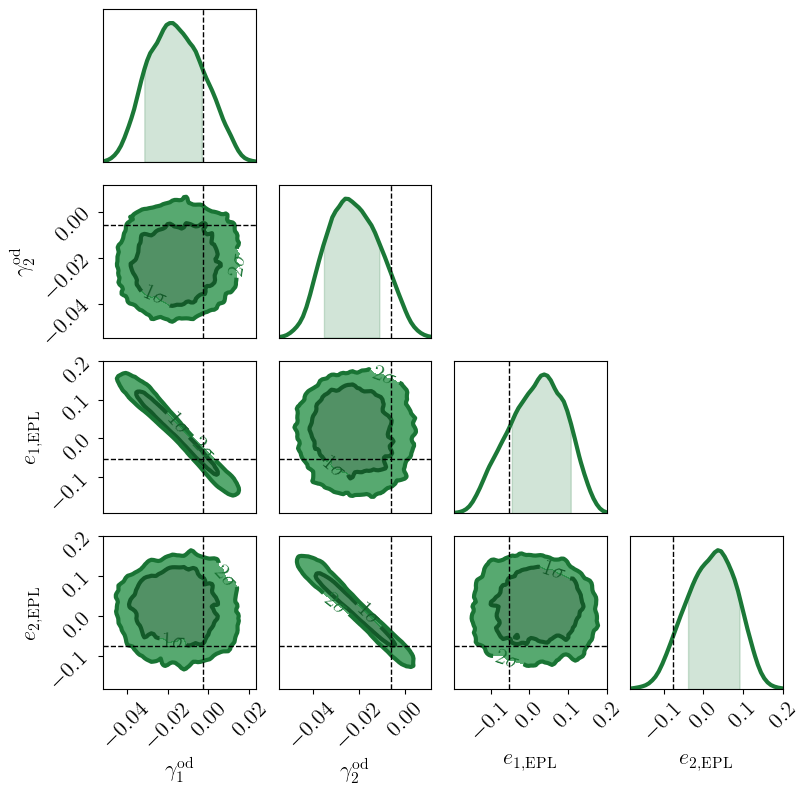

Gelman-Rubin Statistic values for chain Chain 0
$\gamma^{\rm od}_1$: 1.04095 (Passed)
$\gamma^{\rm od}_2$: 1.05428 (Failed)
$e_{1, \rm EPL}$: 1.03705 (Passed)
$e_{2, \rm EPL}$: 1.04980 (Passed)
False


In [34]:
c = ChainConsumer()

n_walkers_min = len(param_mcmc_min)*walker_ratio

my_inds = [0,1,7,8]

fontsize = 16

c.add_chain([samples_mcmc_min[:,ind] for ind in my_inds], 
            walkers = n_walkers_min, 
            parameters = [labels_min[ind] for ind in my_inds])

c.configure(smooth = True, flip = False, summary = False, 
            spacing = 3.0, max_ticks = 4,
            colors = green[2], shade = True, shade_gradient = 0.4, 
            bar_shade = True, linewidths= [3.0],
            tick_font_size=fontsize, label_font_size=fontsize, 
            usetex = True, serif = True,
            contour_labels = 'sigma', contour_label_font_size = fontsize)

fig = c.plotter.plot(truth=[expected_values_min[ind] for ind in my_inds], figsize = (8,8))

fig.patch.set_facecolor('white')

plt.savefig(outpath+'contours_minimal_od_ellipticity.pdf', dpi=300, bbox_inches='tight')

plt.show()

gelman_rubin_converged = c.diagnostic.gelman_rubin() # does this make sense for emcee chains??
print(gelman_rubin_converged)

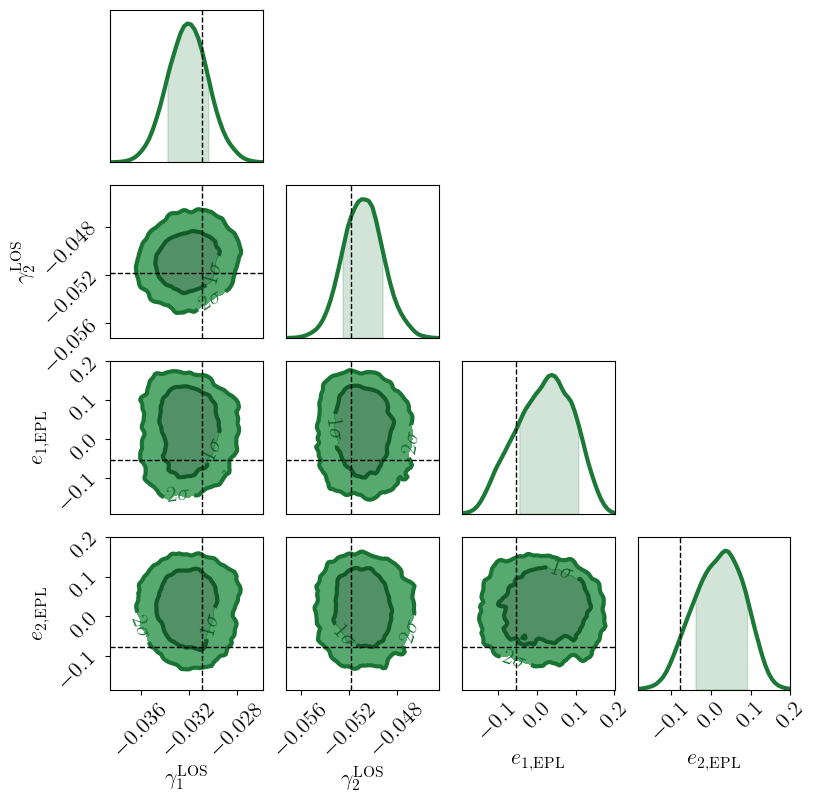

Gelman-Rubin Statistic values for chain Chain 0
$\gamma^{\rm LOS}_1$: 1.00185 (Passed)
$\gamma^{\rm LOS}_2$: 1.00404 (Passed)
$e_{1, \rm EPL}$: 1.03705 (Passed)
$e_{2, \rm EPL}$: 1.04980 (Passed)
True


In [35]:
c = ChainConsumer()

n_walkers_min = len(param_mcmc_min)*walker_ratio

my_inds = [2,3,7,8]

fontsize = 16

c.add_chain([samples_mcmc_min[:,ind] for ind in my_inds], 
            walkers = n_walkers_min, 
            parameters = [labels_min[ind] for ind in my_inds])

c.configure(smooth = True, flip = False, summary = False, 
            spacing = 3.0, max_ticks = 4,
            colors = green[2], shade = True, shade_gradient = 0.4, 
            bar_shade = True, linewidths= [3.0],
            tick_font_size=fontsize, label_font_size=fontsize, 
            usetex = True, serif = True,
            contour_labels = 'sigma', contour_label_font_size = fontsize)

fig = c.plotter.plot(truth=[expected_values_min[ind] for ind in my_inds], figsize = (8,8))

fig.patch.set_facecolor('white')

plt.savefig(outpath+'contours_minimal_ellipticity.pdf', dpi=300, bbox_inches='tight')

plt.show()

gelman_rubin_converged = c.diagnostic.gelman_rubin() # does this make sense for emcee chains??
print(gelman_rubin_converged)

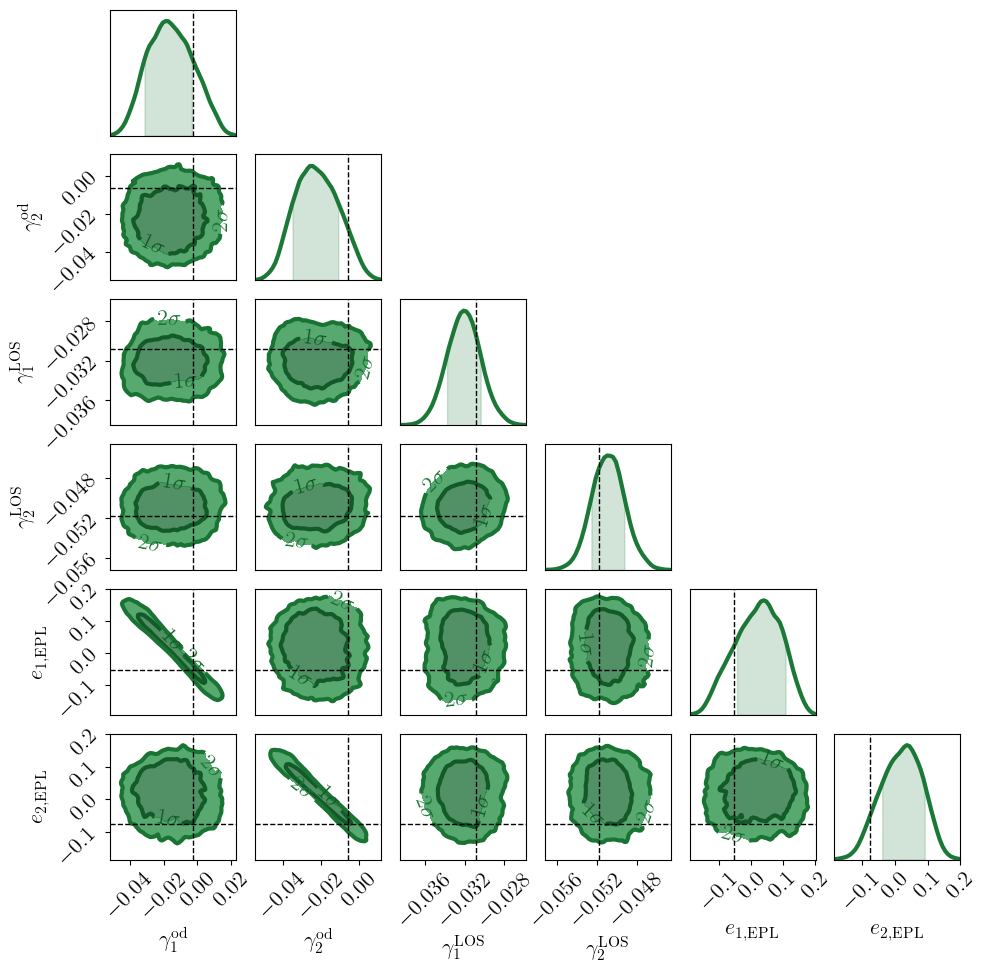

Gelman-Rubin Statistic values for chain Chain 0
$\gamma^{\rm od}_1$: 1.04095 (Passed)
$\gamma^{\rm od}_2$: 1.05428 (Failed)
$\gamma^{\rm LOS}_1$: 1.00185 (Passed)
$\gamma^{\rm LOS}_2$: 1.00404 (Passed)
$e_{1, \rm EPL}$: 1.03705 (Passed)
$e_{2, \rm EPL}$: 1.04980 (Passed)
False


In [36]:
c = ChainConsumer()

n_walkers_min = len(param_mcmc_min)*walker_ratio

my_inds = [0,1,2,3,7,8]

fontsize = 16

c.add_chain([samples_mcmc_min[:,ind] for ind in my_inds], 
            walkers = n_walkers_min, 
            parameters = [labels_min[ind] for ind in my_inds])

c.configure(smooth = True, flip = False, summary = False, 
            spacing = 3.0, max_ticks = 4,
            colors = green[2], shade = True, shade_gradient = 0.4, 
            bar_shade = True, linewidths= [3.0],
            tick_font_size=fontsize, label_font_size=fontsize, 
            usetex = True, serif = True,
            contour_labels = 'sigma', contour_label_font_size = fontsize)

fig = c.plotter.plot(truth=[expected_values_min[ind] for ind in my_inds], figsize = (10,10))

fig.patch.set_facecolor('white')

plt.savefig(outpath+'contours_minimal_all.pdf', dpi=300, bbox_inches='tight')

plt.show()

gelman_rubin_converged = c.diagnostic.gelman_rubin() # does this make sense for emcee chains??
print(gelman_rubin_converged)

[Back to contents](#contents)